Found 902 images belonging to 9 classes.
Found 1698 images belonging to 9 classes.
Epoch 1/20
14/14 [==============================] - 6s 400ms/step - loss: 1.8209 - accuracy: 0.3126 - val_loss: 1.0400 - val_accuracy: 0.7981
Epoch 2/20
14/14 [==============================] - 6s 404ms/step - loss: 0.9035 - accuracy: 0.6802 - val_loss: 0.5256 - val_accuracy: 0.8359
Epoch 3/20
14/14 [==============================] - 5s 391ms/step - loss: 0.6148 - accuracy: 0.7697 - val_loss: 0.3649 - val_accuracy: 0.8804
Epoch 4/20
14/14 [==============================] - 5s 392ms/step - loss: 0.4099 - accuracy: 0.8520 - val_loss: 0.3069 - val_accuracy: 0.9020
Epoch 5/20
14/14 [==============================] - 5s 393ms/step - loss: 0.2957 - accuracy: 0.9057 - val_loss: 0.2197 - val_accuracy: 0.9297
Epoch 6/20
14/14 [==============================] - 5s 389ms/step - loss: 0.1936 - accuracy: 0.9356 - val_loss: 0.1879 - val_accuracy: 0.9363
Epoch 7/20
14/14 [==============================] - 6s 409ms/step

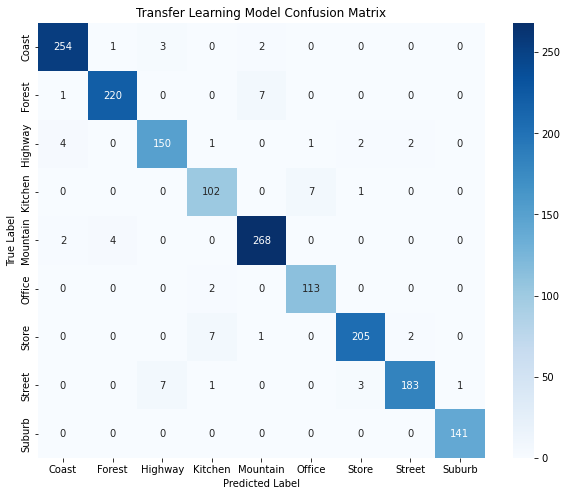

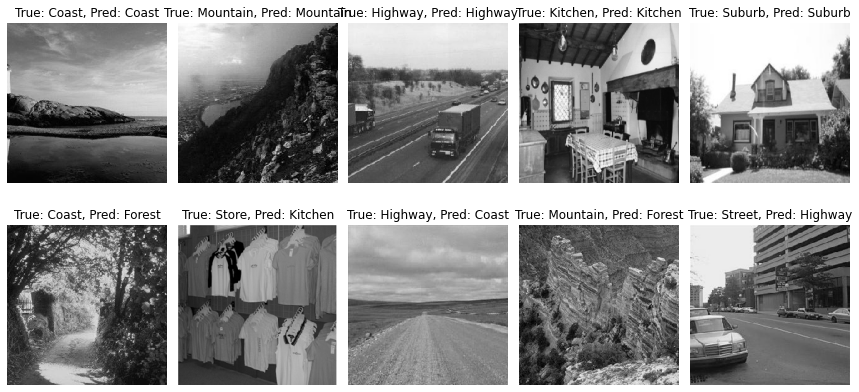

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up directories and image size
train_dir = 'organized_data/train'
test_dir = 'organized_data/validation'
img_size = 224  # Standard VGG16 input size
batch_size = 64

# Define the image data generators for loading the dataset
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the VGG16 model with pre-trained weights, excluding the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze all layers of the base model first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 4 layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom classification layers on top of VGG16
model = models.Sequential()
model.add(base_model)  # Add the pre-trained VGG16 base
model.add(layers.GlobalAveragePooling2D())  # Global average pooling instead of flattening
model.add(layers.Dense(512, activation='relu'))  # Fully connected layer with 512 units
model.add(layers.Dropout(0.5))  # Adding dropout for regularization
model.add(layers.Dense(9, activation='softmax'))  # New output layer with 9 classes

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,  # Similar to problem 2
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Evaluate the model on the test set for top-1 accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f'Transfer Learning with VGG16 Test Accuracy: {test_acc:.4f}')

# Get predictions
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels and class labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate top-1 accuracy (already evaluated above)
top_1_acc = accuracy_score(y_true, y_pred)
print(f'Top-1 Accuracy: {top_1_acc:.4f}')

# Calculate top-3 accuracy
def top_3_accuracy(y_true, y_pred_prob):
    top_3_pred = np.argsort(y_pred_prob, axis=1)[:, -3:]
    return np.mean([1 if y_true[i] in top_3_pred[i] else 0 for i in range(len(y_true))])

top_3_acc = top_3_accuracy(y_true, y_pred_prob)
print(f'Top-3 Accuracy: {top_3_acc:.4f}')

# Confusion matrix
cm_transfer = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_transfer, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Transfer Learning Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Retrieve full test set images and labels for visualization
test_images, test_labels = [], []
for i in range(len(test_generator)):
    images_batch, labels_batch = next(test_generator)
    test_images.append(images_batch)
    test_labels.append(labels_batch)

# Convert lists to arrays
test_images = np.vstack(test_images)
test_labels = np.argmax(np.vstack(test_labels), axis=1)

# Function to plot correct and incorrect classifications
def plot_correct_incorrect_images(predictions, labels, images, class_labels, n_correct=5, n_incorrect=5):
    correct = np.where(predictions == labels)[0]
    incorrect = np.where(predictions != labels)[0]

    # Adjust the number of correct and incorrect images to the available count
    n_correct = min(n_correct, len(correct))
    n_incorrect = min(n_incorrect, len(incorrect))

    if n_correct < 5 or n_incorrect < 5:
        print(f"Warning: There are only {n_correct} correct and {n_incorrect} incorrect predictions available.")

    # Plot the correct predictions
    plt.figure(figsize=(12, 6))
    
    # Plot n correct predictions
    for i, idx in enumerate(np.random.choice(correct, n_correct, replace=False)):
        plt.subplot(2, n_correct, i + 1)
        plt.imshow(images[idx])
        true_label = class_labels[labels[idx]]
        pred_label = class_labels[predictions[idx]]
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')

    # Plot n incorrect predictions
    for i, idx in enumerate(np.random.choice(incorrect, n_incorrect, replace=False)):
        plt.subplot(2, n_incorrect, i + 1 + n_correct)
        plt.imshow(images[idx])
        true_label = class_labels[labels[idx]]
        pred_label = class_labels[predictions[idx]]
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Plot 5 correct and 5 incorrect predictions from the full test set
plot_correct_incorrect_images(y_pred, test_labels, test_images, class_labels)